
# AI-Based Network Anomaly Detection 
## CNN & LSTM using UNSW-NB15 Dataset

This notebook includes:
- CNN and LSTM models
- Accuracy improvement techniques

---


In [16]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Dense, Flatten,
    Dropout, LSTM, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


## 2. Load Dataset

In [17]:

TRAIN_PATH = r"data/UNSW_NB15_testing-set(in).csv"
TEST_PATH  = r"data/UNSW_NB15_training-set(in).csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

train_df.head()


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0



## 3. Data Representation & Feature Relationships

This section visualizes:
- Distribution of normal vs attack traffic
- Correlation between numerical features
- Relationship of key features with attack labels

These visualizations help understand **which features influence intrusion detection**.


### 3.1 Class Distribution

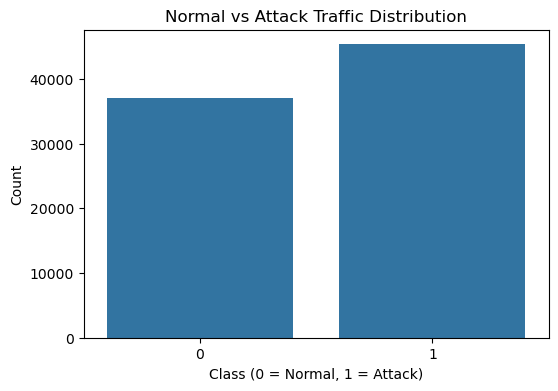

In [18]:

plt.figure(figsize=(6,4))
sns.countplot(x=train_df['label'])
plt.title("Normal vs Attack Traffic Distribution")
plt.xlabel("Class (0 = Normal, 1 = Attack)")
plt.ylabel("Count")
plt.show()


### 3.2 Feature Correlation Heatmap (Top Features)

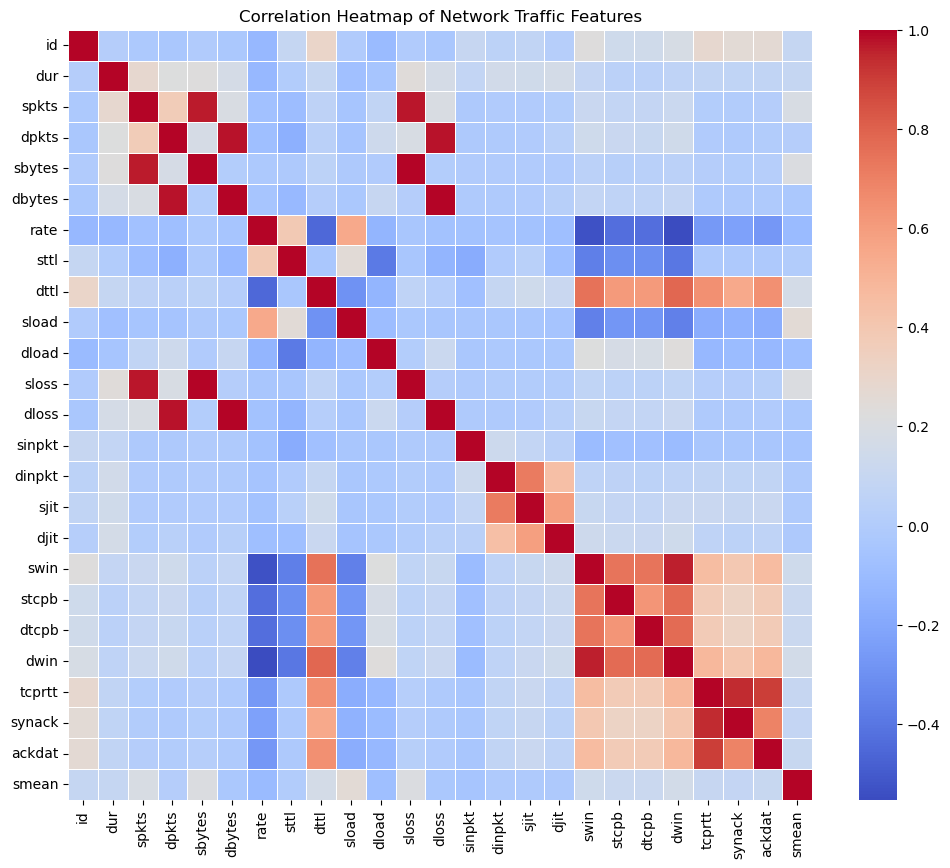

In [19]:

numeric_df = train_df.select_dtypes(include=['int64', 'float64'])

corr = numeric_df.iloc[:, :25].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Network Traffic Features")
plt.show()


### 3.3 Feature vs Label Relationship

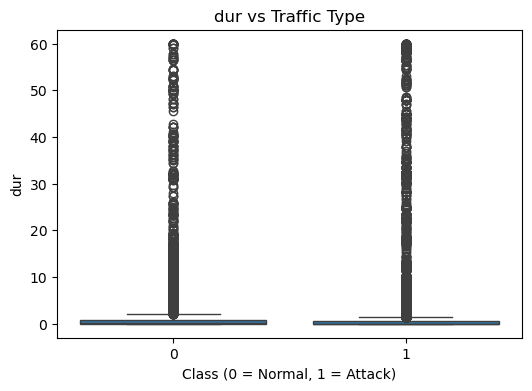

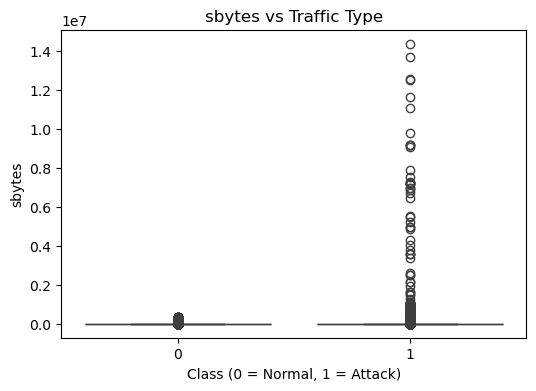

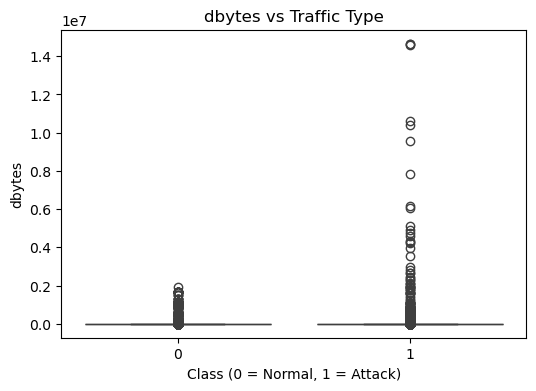

In [20]:

features_to_plot = ['dur', 'sbytes', 'dbytes']

for feature in features_to_plot:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=train_df['label'], y=train_df[feature])
    plt.title(f"{feature} vs Traffic Type")
    plt.xlabel("Class (0 = Normal, 1 = Attack)")
    plt.show()


## 4. Encode Categorical Features

In [21]:

categorical_cols = train_df.select_dtypes(include=['object']).columns
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    combined = pd.concat([train_df[col], test_df[col]])
    le.fit(combined)

    train_df[col] = le.transform(train_df[col])
    test_df[col]  = le.transform(test_df[col])

    encoders[col] = le


## 5. Feature–Label Split & Scaling

In [22]:

X_train = train_df.drop(columns=['label'])
y_train = train_df['label']

X_test = test_df.drop(columns=['label'])
y_test = test_df['label']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

X_train_np = np.asarray(X_train)
X_test_np  = np.asarray(X_test)


## 6. Handle Class Imbalance

In [23]:

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight = dict(enumerate(class_weights))
class_weight


{0: np.float64(1.1125945945945945), 1: np.float64(0.9081002382423012)}

## 7. CNN Model

In [24]:

X_train_cnn = X_train_np.reshape(X_train_np.shape[0], X_train_np.shape[1], 1)
X_test_cnn  = X_test_np.reshape(X_test_np.shape[0], X_test_np.shape[1], 1)

cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_model.fit(
    X_train_cnn,
    y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    class_weight=class_weight,
    callbacks=[early_stop]
)


E:\ProgramFiles\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.9626 - loss: 0.1148 - val_accuracy: 0.2591 - val_loss: 2.9453
Epoch 2/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9861 - loss: 0.0439 - val_accuracy: 0.2685 - val_loss: 3.2399
Epoch 3/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9906 - loss: 0.0321 - val_accuracy: 0.2785 - val_loss: 2.8237
Epoch 4/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9915 - loss: 0.0290 - val_accuracy: 0.3195 - val_loss: 2.9032
Epoch 5/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9924 - loss: 0.0254 - val_accuracy: 0.2807 - val_loss: 2.9676
Epoch 6/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9935 - loss: 0.0219 - val_accuracy: 0.2900 - val_loss: 3.7805
Epoch 7/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9937 - loss: 0.0214 - val_accuracy: 0.3316 - val_loss: 2.7300
Epoch 8/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9940 - loss: 0.0208 - val_acc

## CNN Evaluation

In [25]:
cnn_pred = (cnn_model.predict(X_test_cnn) > 0.5).astype(int)
print(confusion_matrix(y_test, cnn_pred))
print(classification_report(y_test, cnn_pred))

5480/5480 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
[[ 50142   5858]
 [  3140 116201]]
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     56000
           1       0.95      0.97      0.96    119341

    accuracy                           0.95    175341
   macro avg       0.95      0.93      0.94    175341
weighted avg       0.95      0.95      0.95    175341



## 8. LSTM Model

In [26]:

X_train_lstm = X_train_np.reshape(X_train_np.shape[0], 1, X_train_np.shape[1])
X_test_lstm  = X_test_np.reshape(X_test_np.shape[0], 1, X_test_np.shape[1])

lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, X_train_np.shape[1])),
    Dropout(0.3),
    LSTM(128),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

lstm_model.fit(
    X_train_lstm,
    y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    class_weight=class_weight,
    callbacks=[early_stop]
)


Epoch 1/50


E:\ProgramFiles\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9537 - loss: 0.1218 - val_accuracy: 0.6279 - val_loss: 0.6900
Epoch 2/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9905 - loss: 0.0267 - val_accuracy: 0.5260 - val_loss: 1.0404
Epoch 3/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9971 - loss: 0.0099 - val_accuracy: 0.4762 - val_loss: 1.3636
Epoch 4/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9987 - loss: 0.0045 - val_accuracy: 0.5030 - val_loss: 1.4665
Epoch 5/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9993 - loss: 0.0025 - val_accuracy: 0.6983 - val_loss: 0.7832
Epoch 6/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9994 - loss: 0.0018 - val_accuracy: 0.8218 - val_loss: 0.4792
Epoch 7/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 0.8470 - val_loss: 0.3918
Epoch 8/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9998 - loss: 7.4675e-04 - val_accuracy: 0.8274 - 

## LSTM Evaluation

In [27]:
lstm_pred = (lstm_model.predict(X_test_lstm) > 0.5).astype(int)

print(confusion_matrix(y_test, lstm_pred))
print(classification_report(y_test, lstm_pred))


5480/5480 ━━━━━━━━━━━━━━━━━━━━ 6s 963us/step
[[ 54659   1341]
 [    21 119320]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56000
           1       0.99      1.00      0.99    119341

    accuracy                           0.99    175341
   macro avg       0.99      0.99      0.99    175341
weighted avg       0.99      0.99      0.99    175341



## Saving Models

In [30]:
cnn_model.save("cnn_nids_model.keras")


In [31]:
lstm_model.save("lstm_nids_model.keras")
